In [1]:
%tensorflow_version 1.X

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.X`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
#Installing BERT module
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.4MB/s 


## Import libraries

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

tensorflow version :  1.15.2
tensorflow_hub version :  0.8.0



## Load the data

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O bbc-text.csv

--2020-07-16 06:54:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘bbc-text.csv’

bbc-text.csv        100%[===================>]   4.82M  --.-KB/s    in 0.06s   

2020-07-16 06:54:36 (86.9 MB/s) - ‘bbc-text.csv’ saved [5057493/5057493]



In [5]:
# Set the output directory for saving model file
OUTPUT_DIR = 'BERT'

data_source = "bbc-text.csv"

data_df = pd.read_csv(data_source, encoding='utf8', delimiter=',')
print(data_df.head(10))

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...
5       politics  howard hits back at mongrel jibe michael howar...
6       politics  blair prepares to name poll date tony blair is...
7          sport  henman hopes ended in dubai third seed tim hen...
8          sport  wilkinson fit to face edinburgh england captai...
9  entertainment  last star wars  not for children  the sixth an...


In [6]:
#'tech' 'business' 'sport' 'entertainment' 'politics' 
# 0 1 2 3 4
data_df = data_df.replace({'category':{'tech':0, 'business':1, 'sport':2, 'entertainment':3, 'politics':4}})

In [7]:
print(data_df.head(10))

   category                                               text
0         0  tv future in the hands of viewers with home th...
1         1  worldcom boss  left books alone  former worldc...
2         2  tigers wary of farrell  gamble  leicester say ...
3         2  yeading face newcastle in fa cup premiership s...
4         3  ocean s twelve raids box office ocean s twelve...
5         4  howard hits back at mongrel jibe michael howar...
6         4  blair prepares to name poll date tony blair is...
7         2  henman hopes ended in dubai third seed tim hen...
8         2  wilkinson fit to face edinburgh england captai...
9         3  last star wars  not for children  the sixth an...


In [8]:
train, val =  train_test_split(data_df, test_size = 0.2, random_state = 100)

In [9]:
#Training set sample
print(train.head(5))

print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)

      category                                               text
1763         2  mourinho to escape fa charge chelsea boss jose...
1354         4  tories attack burglar  u-turns  tory leader mi...
1324         2  harinordoquy suffers france axe number eight i...
1933         3  fears raised over ballet future fewer children...
969          1  steel firm  to cut  45 000 jobs mittal steel  ...
Training Set Shape : (1780, 2)
Validation Set Shape : (445, 2)


In [10]:
#unique classes
train['category'].unique()

array([2, 4, 3, 1, 0])

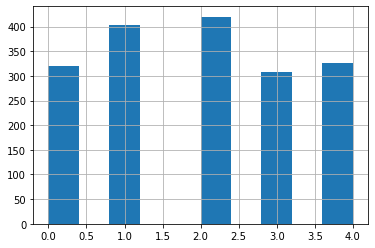

In [11]:
#Distribution of classes
train['category'].hist()

In [12]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'category'
# The list containing all the classes (train['SECTION'].unique())
label_list = [0, 1, 2, 3, 4]

## Data preprocessing

BERT model accept only a specific type of input and the datasets are usually structured to have have the following four features:

guid : A unique id that represents an observation.  
text_a : The text we need to classify into given categories  
text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems.  
label: It consists of the labels or classes or categories that a given text belongs to.  
In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.

In [13]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [14]:
train_InputExamples

1763    <bert.run_classifier.InputExample object at 0x...
1354    <bert.run_classifier.InputExample object at 0x...
1324    <bert.run_classifier.InputExample object at 0x...
1933    <bert.run_classifier.InputExample object at 0x...
969     <bert.run_classifier.InputExample object at 0x...
                              ...                        
350     <bert.run_classifier.InputExample object at 0x...
1930    <bert.run_classifier.InputExample object at 0x...
79      <bert.run_classifier.InputExample object at 0x...
1859    <bert.run_classifier.InputExample object at 0x...
1544    <bert.run_classifier.InputExample object at 0x...
Length: 1780, dtype: object

In [15]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  mourinho to escape fa charge chelsea boss jose mourinho will not face any football association action over the comments he made after their carling cup tie with manchester united.  mourinho intimated that united boss sir alex ferguson influenced referee neale barry after the duo walked down the tunnel together at half-time. but an fa spokesman told bbc sport:  we are not taking action over mourinho.  we have looked at the comments and we have decided that no further action is required. that is the end of it.  mourinho was concerned that ferguson s conversation with barry was followed by an inconsistent display by the official.  i see one referee in the first half and another in the second   said mourinho.  if the fa ask me what happened  i will tell them. what i saw and felt made it easier to understand a few things.   maybe when i turn 60 and have been managing in the same league for 20 years and have t

The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.  
check the model list here: https://tfhub.dev/s?network-architecture=transformer&publisher=google

In [16]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [17]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['mo', '##uri', '##nh', '##o', 'to', 'escape', 'fa', 'charge', 'chelsea', 'boss', 'jose', 'mo', '##uri', '##nh', '##o', 'will', 'not', 'face', 'any', 'football', 'association', 'action', 'over', 'the', 'comments', 'he', 'made', 'after', 'their', 'carl', '##ing', 'cup', 'tie', 'with', 'manchester', 'united', '.', 'mo', '##uri', '##nh', '##o', 'intimate', '##d', 'that', 'united', 'boss', 'sir', 'alex', 'ferguson', 'influenced', 'referee', 'neal', '##e', 'barry', 'after', 'the', 'duo', 'walked', 'down', 'the', 'tunnel', 'together', 'at', 'half', '-', 'time', '.', 'but', 'an', 'fa', 'spokesman', 'told', 'bbc', 'sport', ':', 'we', 'are', 'not', 'taking', 'action', 'over', 'mo', '##uri', '##nh', '##o', '.', 'we', 'have', 'looked', 'at', 'the', 'comments', 'and', 'we', 'have', 'decided', 'that', 'no', 'further', 'action', 'is', 'required', '.', 'that', 'is', 'the', 'end', 'of', 'it', '.', 'mo', '##uri', '##nh', '##o', 'was', 'concerned', 'that', 'ferguson', 's', 'conversation', 'with', 'barry

Format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

In [18]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1780


INFO:tensorflow:Writing example 0 of 1780


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] mo ##uri ##nh ##o to escape fa charge chelsea boss jose mo ##uri ##nh ##o will not face any football association action over the comments he made after their carl ##ing cup tie with manchester united . mo ##uri ##nh ##o intimate ##d that united boss sir alex ferguson influenced referee neal ##e barry after the duo walked down the tunnel together at half - time . but an fa spokesman told bbc sport : we are not taking action over mo ##uri ##nh ##o . we have looked at the comments and we have decided that no further action is required . that is the end of it . mo ##uri ##nh ##o was concerned that ferguson s conversation with barry was followed by an [SEP]


INFO:tensorflow:tokens: [CLS] mo ##uri ##nh ##o to escape fa charge chelsea boss jose mo ##uri ##nh ##o will not face any football association action over the comments he made after their carl ##ing cup tie with manchester united . mo ##uri ##nh ##o intimate ##d that united boss sir alex ferguson influenced referee neal ##e barry after the duo walked down the tunnel together at half - time . but an fa spokesman told bbc sport : we are not taking action over mo ##uri ##nh ##o . we have looked at the comments and we have decided that no further action is required . that is the end of it . mo ##uri ##nh ##o was concerned that ferguson s conversation with barry was followed by an [SEP]


INFO:tensorflow:input_ids: 101 9587 9496 25311 2080 2000 4019 6904 3715 9295 5795 4560 9587 9496 25311 2080 2097 2025 2227 2151 2374 2523 2895 2058 1996 7928 2002 2081 2044 2037 5529 2075 2452 5495 2007 5087 2142 1012 9587 9496 25311 2080 10305 2094 2008 2142 5795 2909 4074 11262 5105 5330 11030 2063 6287 2044 1996 6829 2939 2091 1996 5234 2362 2012 2431 1011 2051 1012 2021 2019 6904 14056 2409 4035 4368 1024 2057 2024 2025 2635 2895 2058 9587 9496 25311 2080 1012 2057 2031 2246 2012 1996 7928 1998 2057 2031 2787 2008 2053 2582 2895 2003 3223 1012 2008 2003 1996 2203 1997 2009 1012 9587 9496 25311 2080 2001 4986 2008 11262 1055 4512 2007 6287 2001 2628 2011 2019 102


INFO:tensorflow:input_ids: 101 9587 9496 25311 2080 2000 4019 6904 3715 9295 5795 4560 9587 9496 25311 2080 2097 2025 2227 2151 2374 2523 2895 2058 1996 7928 2002 2081 2044 2037 5529 2075 2452 5495 2007 5087 2142 1012 9587 9496 25311 2080 10305 2094 2008 2142 5795 2909 4074 11262 5105 5330 11030 2063 6287 2044 1996 6829 2939 2091 1996 5234 2362 2012 2431 1011 2051 1012 2021 2019 6904 14056 2409 4035 4368 1024 2057 2024 2025 2635 2895 2058 9587 9496 25311 2080 1012 2057 2031 2246 2012 1996 7928 1998 2057 2031 2787 2008 2053 2582 2895 2003 3223 1012 2008 2003 1996 2203 1997 2009 1012 9587 9496 25311 2080 2001 4986 2008 11262 1055 4512 2007 6287 2001 2628 2011 2019 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] tori ##es attack bu ##rg ##lar u - turns tory leader michael howard has accused tony blair of performing u - turns over rules on using force against bu ##rg ##lars . the government has ruled out amend ##ing the present law which allows reasonable force in self defence . mr howard branded the decision unacceptable saying : it is not householder ##s who should be frightened it s the bu ##rg ##lars . home secretary charles clarke said ministers had kept to their pledge to review the law . metropolitan police commissioner sir john stevens last month backed a tory attempt to change the law so only householder ##s using gross ##ly di ##sp ##rop ##ort ##ion ##ate force could be prosecuted . the pressure [SEP]


INFO:tensorflow:tokens: [CLS] tori ##es attack bu ##rg ##lar u - turns tory leader michael howard has accused tony blair of performing u - turns over rules on using force against bu ##rg ##lars . the government has ruled out amend ##ing the present law which allows reasonable force in self defence . mr howard branded the decision unacceptable saying : it is not householder ##s who should be frightened it s the bu ##rg ##lars . home secretary charles clarke said ministers had kept to their pledge to review the law . metropolitan police commissioner sir john stevens last month backed a tory attempt to change the law so only householder ##s using gross ##ly di ##sp ##rop ##ort ##ion ##ate force could be prosecuted . the pressure [SEP]


INFO:tensorflow:input_ids: 101 23413 2229 2886 20934 10623 8017 1057 1011 4332 17117 3003 2745 4922 2038 5496 4116 10503 1997 4488 1057 1011 4332 2058 3513 2006 2478 2486 2114 20934 10623 28695 1012 1996 2231 2038 5451 2041 27950 2075 1996 2556 2375 2029 4473 9608 2486 1999 2969 4721 1012 2720 4922 11180 1996 3247 21873 3038 1024 2009 2003 2025 7536 2015 2040 2323 2022 10363 2009 1055 1996 20934 10623 28695 1012 2188 3187 2798 8359 2056 7767 2018 2921 2000 2037 16393 2000 3319 1996 2375 1012 4956 2610 5849 2909 2198 8799 2197 3204 6153 1037 17117 3535 2000 2689 1996 2375 2061 2069 7536 2015 2478 7977 2135 4487 13102 18981 11589 3258 3686 2486 2071 2022 21651 1012 1996 3778 102


INFO:tensorflow:input_ids: 101 23413 2229 2886 20934 10623 8017 1057 1011 4332 17117 3003 2745 4922 2038 5496 4116 10503 1997 4488 1057 1011 4332 2058 3513 2006 2478 2486 2114 20934 10623 28695 1012 1996 2231 2038 5451 2041 27950 2075 1996 2556 2375 2029 4473 9608 2486 1999 2969 4721 1012 2720 4922 11180 1996 3247 21873 3038 1024 2009 2003 2025 7536 2015 2040 2323 2022 10363 2009 1055 1996 20934 10623 28695 1012 2188 3187 2798 8359 2056 7767 2018 2921 2000 2037 16393 2000 3319 1996 2375 1012 4956 2610 5849 2909 2198 8799 2197 3204 6153 1037 17117 3535 2000 2689 1996 2375 2061 2069 7536 2015 2478 7977 2135 4487 13102 18981 11589 3258 3686 2486 2071 2022 21651 1012 1996 3778 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hari ##nor ##do ##qu ##y suffers france axe number eight im ##ano ##l hari ##nor ##do ##qu ##y has been dropped from france s squad for the six nations match with ireland in dublin on 12 march . hari ##nor ##do ##qu ##y was a second - half replacement in last saturday s 24 - 18 defeat to wales . bo ##urg ##oin lock pascal pa ##pe who has recovered from a sp ##rained ankle returns to the 22 - man squad . wing cedric hey ##mans and lu ##do ##vic val ##bon come in for au ##rel ##ien rouge ##rie and jean - philippe grand ##cl ##aud ##e . rouge ##rie hurt his chest against wales while grand ##cl ##aud ##e was a second - [SEP]


INFO:tensorflow:tokens: [CLS] hari ##nor ##do ##qu ##y suffers france axe number eight im ##ano ##l hari ##nor ##do ##qu ##y has been dropped from france s squad for the six nations match with ireland in dublin on 12 march . hari ##nor ##do ##qu ##y was a second - half replacement in last saturday s 24 - 18 defeat to wales . bo ##urg ##oin lock pascal pa ##pe who has recovered from a sp ##rained ankle returns to the 22 - man squad . wing cedric hey ##mans and lu ##do ##vic val ##bon come in for au ##rel ##ien rouge ##rie and jean - philippe grand ##cl ##aud ##e . rouge ##rie hurt his chest against wales while grand ##cl ##aud ##e was a second - [SEP]


INFO:tensorflow:input_ids: 101 21291 12131 3527 28940 2100 17567 2605 12946 2193 2809 10047 6761 2140 21291 12131 3527 28940 2100 2038 2042 3333 2013 2605 1055 4686 2005 1996 2416 3741 2674 2007 3163 1999 5772 2006 2260 2233 1012 21291 12131 3527 28940 2100 2001 1037 2117 1011 2431 6110 1999 2197 5095 1055 2484 1011 2324 4154 2000 3575 1012 8945 12514 28765 5843 17878 6643 5051 2040 2038 6757 2013 1037 11867 27361 10792 5651 2000 1996 2570 1011 2158 4686 1012 3358 26170 4931 15154 1998 11320 3527 7903 11748 11735 2272 1999 2005 8740 16570 9013 12801 7373 1998 3744 1011 11169 2882 20464 19513 2063 1012 12801 7373 3480 2010 3108 2114 3575 2096 2882 20464 19513 2063 2001 1037 2117 1011 102


INFO:tensorflow:input_ids: 101 21291 12131 3527 28940 2100 17567 2605 12946 2193 2809 10047 6761 2140 21291 12131 3527 28940 2100 2038 2042 3333 2013 2605 1055 4686 2005 1996 2416 3741 2674 2007 3163 1999 5772 2006 2260 2233 1012 21291 12131 3527 28940 2100 2001 1037 2117 1011 2431 6110 1999 2197 5095 1055 2484 1011 2324 4154 2000 3575 1012 8945 12514 28765 5843 17878 6643 5051 2040 2038 6757 2013 1037 11867 27361 10792 5651 2000 1996 2570 1011 2158 4686 1012 3358 26170 4931 15154 1998 11320 3527 7903 11748 11735 2272 1999 2005 8740 16570 9013 12801 7373 1998 3744 1011 11169 2882 20464 19513 2063 1012 12801 7373 3480 2010 3108 2114 3575 2096 2882 20464 19513 2063 2001 1037 2117 1011 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] fears raised over ballet future fewer children in the uk are following in the dai ##nty footsteps of dancers like dar ##cey bus ##sell and carving out potential careers as ballet dancers . new research from the royal academy of dance ( ra ##d ) has found fewer children over the age of 10 are attending ballet classes and taking exams in the discipline . the organisation blame ##s the growing popularity of computer games and other changes in lifestyle . and there are fears that if the trend is not reversed there could be fewer british ballet stars in the future . the ra ##d found that the number of young ##sters taking their ballet exams drops by almost 70 % after the age of [SEP]


INFO:tensorflow:tokens: [CLS] fears raised over ballet future fewer children in the uk are following in the dai ##nty footsteps of dancers like dar ##cey bus ##sell and carving out potential careers as ballet dancers . new research from the royal academy of dance ( ra ##d ) has found fewer children over the age of 10 are attending ballet classes and taking exams in the discipline . the organisation blame ##s the growing popularity of computer games and other changes in lifestyle . and there are fears that if the trend is not reversed there could be fewer british ballet stars in the future . the ra ##d found that the number of young ##sters taking their ballet exams drops by almost 70 % after the age of [SEP]


INFO:tensorflow:input_ids: 101 10069 2992 2058 7250 2925 8491 2336 1999 1996 2866 2024 2206 1999 1996 18765 29405 9717 1997 10487 2066 18243 25810 3902 23836 1998 18441 2041 4022 10922 2004 7250 10487 1012 2047 2470 2013 1996 2548 2914 1997 3153 1006 10958 2094 1007 2038 2179 8491 2336 2058 1996 2287 1997 2184 2024 7052 7250 4280 1998 2635 13869 1999 1996 9009 1012 1996 5502 7499 2015 1996 3652 6217 1997 3274 2399 1998 2060 3431 1999 9580 1012 1998 2045 2024 10069 2008 2065 1996 9874 2003 2025 11674 2045 2071 2022 8491 2329 7250 3340 1999 1996 2925 1012 1996 10958 2094 2179 2008 1996 2193 1997 2402 15608 2635 2037 7250 13869 9010 2011 2471 3963 1003 2044 1996 2287 1997 102


INFO:tensorflow:input_ids: 101 10069 2992 2058 7250 2925 8491 2336 1999 1996 2866 2024 2206 1999 1996 18765 29405 9717 1997 10487 2066 18243 25810 3902 23836 1998 18441 2041 4022 10922 2004 7250 10487 1012 2047 2470 2013 1996 2548 2914 1997 3153 1006 10958 2094 1007 2038 2179 8491 2336 2058 1996 2287 1997 2184 2024 7052 7250 4280 1998 2635 13869 1999 1996 9009 1012 1996 5502 7499 2015 1996 3652 6217 1997 3274 2399 1998 2060 3431 1999 9580 1012 1998 2045 2024 10069 2008 2065 1996 9874 2003 2025 11674 2045 2071 2022 8491 2329 7250 3340 1999 1996 2925 1012 1996 10958 2094 2179 2008 1996 2193 1997 2402 15608 2635 2037 7250 13869 9010 2011 2471 3963 1003 2044 1996 2287 1997 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] steel firm to cut 45 000 jobs mit ##tal steel one of the world s largest steel producers could cut up to 45 000 jobs over the next five years its chief executive has said . the netherlands - based company is due to complete its $ 4 . 5 ##bn acquisition of us firm is ##g next month making it one of the largest global firms of its kind . however lakshmi mit ##tal has told investors the combined company will have to shed thousands of jobs . the indian - born magnate did not say where the job losses would fall . mr mit ##tal told us investors that once the acquisition of international steel group was completed the company would aim to reduce [SEP]


INFO:tensorflow:tokens: [CLS] steel firm to cut 45 000 jobs mit ##tal steel one of the world s largest steel producers could cut up to 45 000 jobs over the next five years its chief executive has said . the netherlands - based company is due to complete its $ 4 . 5 ##bn acquisition of us firm is ##g next month making it one of the largest global firms of its kind . however lakshmi mit ##tal has told investors the combined company will have to shed thousands of jobs . the indian - born magnate did not say where the job losses would fall . mr mit ##tal told us investors that once the acquisition of international steel group was completed the company would aim to reduce [SEP]


INFO:tensorflow:input_ids: 101 3886 3813 2000 3013 3429 2199 5841 10210 9080 3886 2028 1997 1996 2088 1055 2922 3886 6443 2071 3013 2039 2000 3429 2199 5841 2058 1996 2279 2274 2086 2049 2708 3237 2038 2056 1012 1996 4549 1011 2241 2194 2003 2349 2000 3143 2049 1002 1018 1012 1019 24700 7654 1997 2149 3813 2003 2290 2279 3204 2437 2009 2028 1997 1996 2922 3795 9786 1997 2049 2785 1012 2174 21352 10210 9080 2038 2409 9387 1996 4117 2194 2097 2031 2000 8328 5190 1997 5841 1012 1996 2796 1011 2141 27470 2106 2025 2360 2073 1996 3105 6409 2052 2991 1012 2720 10210 9080 2409 2149 9387 2008 2320 1996 7654 1997 2248 3886 2177 2001 2949 1996 2194 2052 6614 2000 5547 102


INFO:tensorflow:input_ids: 101 3886 3813 2000 3013 3429 2199 5841 10210 9080 3886 2028 1997 1996 2088 1055 2922 3886 6443 2071 3013 2039 2000 3429 2199 5841 2058 1996 2279 2274 2086 2049 2708 3237 2038 2056 1012 1996 4549 1011 2241 2194 2003 2349 2000 3143 2049 1002 1018 1012 1019 24700 7654 1997 2149 3813 2003 2290 2279 3204 2437 2009 2028 1997 1996 2922 3795 9786 1997 2049 2785 1012 2174 21352 10210 9080 2038 2409 9387 1996 4117 2194 2097 2031 2000 8328 5190 1997 5841 1012 1996 2796 1011 2141 27470 2106 2025 2360 2073 1996 3105 6409 2052 2991 1012 2720 10210 9080 2409 2149 9387 2008 2320 1996 7654 1997 2248 3886 2177 2001 2949 1996 2194 2052 6614 2000 5547 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 445


INFO:tensorflow:Writing example 0 of 445


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] dal ##lag ##lio his own man to the end controversy and lawrence dal ##lag ##lio have never been very far away from each other throughout a glittering international career . even the end of his nine - year career came out of the blue just four days before the start of the season . but then dal ##lag ##lio has always been his own man . ever since emerging onto the international scene dal ##lag ##lio has polar ##ised opinions . to supporters of england dal ##lag ##lio could do no wrong . an integral part of a sustained period of success for england dal ##lag ##lio s crown ##ing glory was his part in the side that won the rugby world cup in 2003 . [SEP]


INFO:tensorflow:tokens: [CLS] dal ##lag ##lio his own man to the end controversy and lawrence dal ##lag ##lio have never been very far away from each other throughout a glittering international career . even the end of his nine - year career came out of the blue just four days before the start of the season . but then dal ##lag ##lio has always been his own man . ever since emerging onto the international scene dal ##lag ##lio has polar ##ised opinions . to supporters of england dal ##lag ##lio could do no wrong . an integral part of a sustained period of success for england dal ##lag ##lio s crown ##ing glory was his part in the side that won the rugby world cup in 2003 . [SEP]


INFO:tensorflow:input_ids: 101 17488 17802 12798 2010 2219 2158 2000 1996 2203 6704 1998 5623 17488 17802 12798 2031 2196 2042 2200 2521 2185 2013 2169 2060 2802 1037 20332 2248 2476 1012 2130 1996 2203 1997 2010 3157 1011 2095 2476 2234 2041 1997 1996 2630 2074 2176 2420 2077 1996 2707 1997 1996 2161 1012 2021 2059 17488 17802 12798 2038 2467 2042 2010 2219 2158 1012 2412 2144 8361 3031 1996 2248 3496 17488 17802 12798 2038 11508 5084 10740 1012 2000 6793 1997 2563 17488 17802 12798 2071 2079 2053 3308 1012 2019 9897 2112 1997 1037 8760 2558 1997 3112 2005 2563 17488 17802 12798 1055 4410 2075 8294 2001 2010 2112 1999 1996 2217 2008 2180 1996 4043 2088 2452 1999 2494 1012 102


INFO:tensorflow:input_ids: 101 17488 17802 12798 2010 2219 2158 2000 1996 2203 6704 1998 5623 17488 17802 12798 2031 2196 2042 2200 2521 2185 2013 2169 2060 2802 1037 20332 2248 2476 1012 2130 1996 2203 1997 2010 3157 1011 2095 2476 2234 2041 1997 1996 2630 2074 2176 2420 2077 1996 2707 1997 1996 2161 1012 2021 2059 17488 17802 12798 2038 2467 2042 2010 2219 2158 1012 2412 2144 8361 3031 1996 2248 3496 17488 17802 12798 2038 11508 5084 10740 1012 2000 6793 1997 2563 17488 17802 12798 2071 2079 2053 3308 1012 2019 9897 2112 1997 1037 8760 2558 1997 3112 2005 2563 17488 17802 12798 1055 4410 2075 8294 2001 2010 2112 1999 1996 2217 2008 2180 1996 4043 2088 2452 1999 2494 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] post - christmas lu ##ll in lending uk mortgage lending showed a post - christmas lu ##ll in january indicating a slowing housing market lend ##ers have said . both the council of mortgage lend ##ers ( cm ##l ) and building society association ( bs ##a ) said lending was down sharply . the cm ##l said gross mortgage lending stood at £1 ##7 . 9 ##bn compared with £2 ##1 . 8 ##bn in january last year . the bs ##a said mortgage approval ##s - loans approved but not yet made - were £2 ##bn down from £2 . 6 ##bn in january 2004 . at the same time the british bankers association ( bb ##a ) said lending was weaker . overall [SEP]


INFO:tensorflow:tokens: [CLS] post - christmas lu ##ll in lending uk mortgage lending showed a post - christmas lu ##ll in january indicating a slowing housing market lend ##ers have said . both the council of mortgage lend ##ers ( cm ##l ) and building society association ( bs ##a ) said lending was down sharply . the cm ##l said gross mortgage lending stood at £1 ##7 . 9 ##bn compared with £2 ##1 . 8 ##bn in january last year . the bs ##a said mortgage approval ##s - loans approved but not yet made - were £2 ##bn down from £2 . 6 ##bn in january 2004 . at the same time the british bankers association ( bb ##a ) said lending was weaker . overall [SEP]


INFO:tensorflow:input_ids: 101 2695 1011 4234 11320 3363 1999 18435 2866 14344 18435 3662 1037 2695 1011 4234 11320 3363 1999 2254 8131 1037 18068 3847 3006 18496 2545 2031 2056 1012 2119 1996 2473 1997 14344 18496 2545 1006 4642 2140 1007 1998 2311 2554 2523 1006 18667 2050 1007 2056 18435 2001 2091 9249 1012 1996 4642 2140 2056 7977 14344 18435 2768 2012 14534 2581 1012 1023 24700 4102 2007 21853 2487 1012 1022 24700 1999 2254 2197 2095 1012 1996 18667 2050 2056 14344 6226 2015 1011 10940 4844 2021 2025 2664 2081 1011 2020 21853 24700 2091 2013 21853 1012 1020 24700 1999 2254 2432 1012 2012 1996 2168 2051 1996 2329 25375 2523 1006 22861 2050 1007 2056 18435 2001 15863 1012 3452 102


INFO:tensorflow:input_ids: 101 2695 1011 4234 11320 3363 1999 18435 2866 14344 18435 3662 1037 2695 1011 4234 11320 3363 1999 2254 8131 1037 18068 3847 3006 18496 2545 2031 2056 1012 2119 1996 2473 1997 14344 18496 2545 1006 4642 2140 1007 1998 2311 2554 2523 1006 18667 2050 1007 2056 18435 2001 2091 9249 1012 1996 4642 2140 2056 7977 14344 18435 2768 2012 14534 2581 1012 1023 24700 4102 2007 21853 2487 1012 1022 24700 1999 2254 2197 2095 1012 1996 18667 2050 2056 14344 6226 2015 1011 10940 4844 2021 2025 2664 2081 1011 2020 21853 24700 2091 2013 21853 1012 1020 24700 1999 2254 2432 1012 2012 1996 2168 2051 1996 2329 25375 2523 1006 22861 2050 1007 2056 18435 2001 15863 1012 3452 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] t - mobile bets on pocket office t - mobile has launched its latest pocket office third - generation ( 3 ##g ) device which also has built - in wi - fi - high - speed wireless net access . unlike other devices where the user has to check which high - speed network is available to transfer data the device selects the fastest one itself . the md ##a iv released in the summer is an upgrade to the company s existing smartphone the 2 . 5 ##g / wi - fi md ##a iii . it reflects the push by mobile firms for devices that are like mini laptop ##s . the device has a display that can be sw ##ive ##lled and [SEP]


INFO:tensorflow:tokens: [CLS] t - mobile bets on pocket office t - mobile has launched its latest pocket office third - generation ( 3 ##g ) device which also has built - in wi - fi - high - speed wireless net access . unlike other devices where the user has to check which high - speed network is available to transfer data the device selects the fastest one itself . the md ##a iv released in the summer is an upgrade to the company s existing smartphone the 2 . 5 ##g / wi - fi md ##a iii . it reflects the push by mobile firms for devices that are like mini laptop ##s . the device has a display that can be sw ##ive ##lled and [SEP]


INFO:tensorflow:input_ids: 101 1056 1011 4684 29475 2006 4979 2436 1056 1011 4684 2038 3390 2049 6745 4979 2436 2353 1011 4245 1006 1017 2290 1007 5080 2029 2036 2038 2328 1011 1999 15536 1011 10882 1011 2152 1011 3177 9949 5658 3229 1012 4406 2060 5733 2073 1996 5310 2038 2000 4638 2029 2152 1011 3177 2897 2003 2800 2000 4651 2951 1996 5080 27034 1996 7915 2028 2993 1012 1996 9108 2050 4921 2207 1999 1996 2621 2003 2019 12200 2000 1996 2194 1055 4493 26381 1996 1016 1012 1019 2290 1013 15536 1011 10882 9108 2050 3523 1012 2009 11138 1996 5245 2011 4684 9786 2005 5733 2008 2024 2066 7163 12191 2015 1012 1996 5080 2038 1037 4653 2008 2064 2022 25430 3512 11001 1998 102


INFO:tensorflow:input_ids: 101 1056 1011 4684 29475 2006 4979 2436 1056 1011 4684 2038 3390 2049 6745 4979 2436 2353 1011 4245 1006 1017 2290 1007 5080 2029 2036 2038 2328 1011 1999 15536 1011 10882 1011 2152 1011 3177 9949 5658 3229 1012 4406 2060 5733 2073 1996 5310 2038 2000 4638 2029 2152 1011 3177 2897 2003 2800 2000 4651 2951 1996 5080 27034 1996 7915 2028 2993 1012 1996 9108 2050 4921 2207 1999 1996 2621 2003 2019 12200 2000 1996 2194 1055 4493 26381 1996 1016 1012 1019 2290 1013 15536 1011 10882 9108 2050 3523 1012 2009 11138 1996 5245 2011 4684 9786 2005 5733 2008 2024 2066 7163 12191 2015 1012 1996 5080 2038 1037 4653 2008 2064 2022 25430 3512 11001 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] kin ##nock to urge reform in lords neil kin ##nock has said his acceptance of a seat in the house of lords will allow him to help achieve further progress with substantial democratic reform . on the bbc s breakfast with frost it was put to mr kin ##nock that he had once referred to lords members as brig ##ands mug ##gers bribe ##rs and gangster ##s . but the outgoing european commissioner said his comments - made some 26 years ago - needed to be put in context . he said advocates for reform needed to be inside the lords to vote for it . it was pointed out to me that if the additional democratic reform is going to take place it is going [SEP]


INFO:tensorflow:tokens: [CLS] kin ##nock to urge reform in lords neil kin ##nock has said his acceptance of a seat in the house of lords will allow him to help achieve further progress with substantial democratic reform . on the bbc s breakfast with frost it was put to mr kin ##nock that he had once referred to lords members as brig ##ands mug ##gers bribe ##rs and gangster ##s . but the outgoing european commissioner said his comments - made some 26 years ago - needed to be put in context . he said advocates for reform needed to be inside the lords to vote for it . it was pointed out to me that if the additional democratic reform is going to take place it is going [SEP]


INFO:tensorflow:input_ids: 101 12631 18057 2000 9075 5290 1999 8140 6606 12631 18057 2038 2056 2010 9920 1997 1037 2835 1999 1996 2160 1997 8140 2097 3499 2032 2000 2393 6162 2582 5082 2007 6937 3537 5290 1012 2006 1996 4035 1055 6350 2007 10097 2009 2001 2404 2000 2720 12631 18057 2008 2002 2018 2320 3615 2000 8140 2372 2004 16908 29560 14757 15776 26470 2869 1998 20067 2015 1012 2021 1996 22011 2647 5849 2056 2010 7928 1011 2081 2070 2656 2086 3283 1011 2734 2000 2022 2404 1999 6123 1012 2002 2056 13010 2005 5290 2734 2000 2022 2503 1996 8140 2000 3789 2005 2009 1012 2009 2001 4197 2041 2000 2033 2008 2065 1996 3176 3537 5290 2003 2183 2000 2202 2173 2009 2003 2183 102


INFO:tensorflow:input_ids: 101 12631 18057 2000 9075 5290 1999 8140 6606 12631 18057 2038 2056 2010 9920 1997 1037 2835 1999 1996 2160 1997 8140 2097 3499 2032 2000 2393 6162 2582 5082 2007 6937 3537 5290 1012 2006 1996 4035 1055 6350 2007 10097 2009 2001 2404 2000 2720 12631 18057 2008 2002 2018 2320 3615 2000 8140 2372 2004 16908 29560 14757 15776 26470 2869 1998 20067 2015 1012 2021 1996 22011 2647 5849 2056 2010 7928 1011 2081 2070 2656 2086 3283 1011 2734 2000 2022 2404 1999 6123 1012 2002 2056 13010 2005 5290 2734 2000 2022 2503 1996 8140 2000 3789 2005 2009 1012 2009 2001 4197 2041 2000 2033 2008 2065 1996 3176 3537 5290 2003 2183 2000 2202 2173 2009 2003 2183 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sony ps ##p tipped as a must - have sony s playstation portable is the top uk ga ##dget for 2005 according to a round - up of ultimate gi ##z ##mos compiled by stuff magazine . it beats the ipod into second place in the top ten essential ##s list which predict ##s what ga ##dget - lovers are likely to cove ##t this year . owning all 10 ga ##dgets will set the ga ##dget lover back £ ##7 45 ##5 . that is £1 000 cheaper than last year s list due to falling manufacturing costs making ga ##dgets more affordable . portable ga ##dgets dominate the list including sharp s 90 ##2 3 ##g mobile phone the pen ##ta ##x opt ##io [SEP]


INFO:tensorflow:tokens: [CLS] sony ps ##p tipped as a must - have sony s playstation portable is the top uk ga ##dget for 2005 according to a round - up of ultimate gi ##z ##mos compiled by stuff magazine . it beats the ipod into second place in the top ten essential ##s list which predict ##s what ga ##dget - lovers are likely to cove ##t this year . owning all 10 ga ##dgets will set the ga ##dget lover back £ ##7 45 ##5 . that is £1 000 cheaper than last year s list due to falling manufacturing costs making ga ##dgets more affordable . portable ga ##dgets dominate the list including sharp s 90 ##2 3 ##g mobile phone the pen ##ta ##x opt ##io [SEP]


INFO:tensorflow:input_ids: 101 8412 8827 2361 11182 2004 1037 2442 1011 2031 8412 1055 9160 12109 2003 1996 2327 2866 11721 24291 2005 2384 2429 2000 1037 2461 1011 2039 1997 7209 21025 2480 15530 9227 2011 4933 2932 1012 2009 10299 1996 26322 2046 2117 2173 1999 1996 2327 2702 6827 2015 2862 2029 16014 2015 2054 11721 24291 1011 10205 2024 3497 2000 11821 2102 2023 2095 1012 19273 2035 2184 11721 28682 2097 2275 1996 11721 24291 7089 2067 1069 2581 3429 2629 1012 2008 2003 14534 2199 16269 2084 2197 2095 1055 2862 2349 2000 4634 5814 5366 2437 11721 28682 2062 15184 1012 12109 11721 28682 16083 1996 2862 2164 4629 1055 3938 2475 1017 2290 4684 3042 1996 7279 2696 2595 23569 3695 102


INFO:tensorflow:input_ids: 101 8412 8827 2361 11182 2004 1037 2442 1011 2031 8412 1055 9160 12109 2003 1996 2327 2866 11721 24291 2005 2384 2429 2000 1037 2461 1011 2039 1997 7209 21025 2480 15530 9227 2011 4933 2932 1012 2009 10299 1996 26322 2046 2117 2173 1999 1996 2327 2702 6827 2015 2862 2029 16014 2015 2054 11721 24291 1011 10205 2024 3497 2000 11821 2102 2023 2095 1012 19273 2035 2184 11721 28682 2097 2275 1996 11721 24291 7089 2067 1069 2581 3429 2629 1012 2008 2003 14534 2199 16269 2084 2197 2095 1055 2862 2349 2000 4634 5814 5366 2437 11721 28682 2062 15184 1012 12109 11721 28682 16083 1996 2862 2164 4629 1055 3938 2475 1017 2290 4684 3042 1996 7279 2696 2595 23569 3695 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


In [19]:
print(len(train_features))
print(len(val_features))

1780
445


## Create multi-class classifier model

In [20]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [21]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [22]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [23]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'BERT', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb4a00d3eb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'BERT', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb4a00d3eb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [24]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

## Training and evaluating

In [25]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into BERT/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into BERT/model.ckpt.


INFO:tensorflow:loss = 1.6868038, step = 0


INFO:tensorflow:loss = 1.6868038, step = 0


INFO:tensorflow:global_step/sec: 1.56525


INFO:tensorflow:global_step/sec: 1.56525


INFO:tensorflow:loss = 0.017032078, step = 100 (63.889 sec)


INFO:tensorflow:loss = 0.017032078, step = 100 (63.889 sec)


INFO:tensorflow:Saving checkpoints for 166 into BERT/model.ckpt.


INFO:tensorflow:Saving checkpoints for 166 into BERT/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0050199768.


INFO:tensorflow:Loss for final step: 0.0050199768.


Training took time  0:02:32.398691


In [26]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-07-16T06:57:57Z


INFO:tensorflow:Starting evaluation at 2020-07-16T06:57:57Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-166


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-166


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-07-16-06:58:06


INFO:tensorflow:Finished evaluation at 2020-07-16-06:58:06


INFO:tensorflow:Saving dict for global step 166: eval_accuracy = 0.98202246, false_negatives = 0.0, false_positives = 4.0, global_step = 166, loss = 0.0840102, true_negatives = 76.0, true_positives = 365.0


INFO:tensorflow:Saving dict for global step 166: eval_accuracy = 0.98202246, false_negatives = 0.0, false_positives = 4.0, global_step = 166, loss = 0.0840102, true_negatives = 76.0, true_positives = 365.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 166: BERT/model.ckpt-166


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 166: BERT/model.ckpt-166


{'eval_accuracy': 0.98202246,
 'false_negatives': 0.0,
 'false_positives': 4.0,
 'global_step': 166,
 'loss': 0.0840102,
 'true_negatives': 76.0,
 'true_positives': 365.0}

## Predict val set

In [27]:
# 'tech' 'business' 'sport' 'entertainment' 'politics' 
# 0 1 2 3 4

# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ['tech', 'business', 'sport', 'entertainment', 'politics']

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [30]:
# Load validation data again
pred_sentences = list(val['text'])
labels_val = list(val['category'])

In [31]:
predictions = getPrediction(pred_sentences)

INFO:tensorflow:Writing example 0 of 445


INFO:tensorflow:Writing example 0 of 445


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] dal ##lag ##lio his own man to the end controversy and lawrence dal ##lag ##lio have never been very far away from each other throughout a glittering international career . even the end of his nine - year career came out of the blue just four days before the start of the season . but then dal ##lag ##lio has always been his own man . ever since emerging onto the international scene dal ##lag ##lio has polar ##ised opinions . to supporters of england dal ##lag ##lio could do no wrong . an integral part of a sustained period of success for england dal ##lag ##lio s crown ##ing glory was his part in the side that won the rugby world cup in 2003 . [SEP]


INFO:tensorflow:tokens: [CLS] dal ##lag ##lio his own man to the end controversy and lawrence dal ##lag ##lio have never been very far away from each other throughout a glittering international career . even the end of his nine - year career came out of the blue just four days before the start of the season . but then dal ##lag ##lio has always been his own man . ever since emerging onto the international scene dal ##lag ##lio has polar ##ised opinions . to supporters of england dal ##lag ##lio could do no wrong . an integral part of a sustained period of success for england dal ##lag ##lio s crown ##ing glory was his part in the side that won the rugby world cup in 2003 . [SEP]


INFO:tensorflow:input_ids: 101 17488 17802 12798 2010 2219 2158 2000 1996 2203 6704 1998 5623 17488 17802 12798 2031 2196 2042 2200 2521 2185 2013 2169 2060 2802 1037 20332 2248 2476 1012 2130 1996 2203 1997 2010 3157 1011 2095 2476 2234 2041 1997 1996 2630 2074 2176 2420 2077 1996 2707 1997 1996 2161 1012 2021 2059 17488 17802 12798 2038 2467 2042 2010 2219 2158 1012 2412 2144 8361 3031 1996 2248 3496 17488 17802 12798 2038 11508 5084 10740 1012 2000 6793 1997 2563 17488 17802 12798 2071 2079 2053 3308 1012 2019 9897 2112 1997 1037 8760 2558 1997 3112 2005 2563 17488 17802 12798 1055 4410 2075 8294 2001 2010 2112 1999 1996 2217 2008 2180 1996 4043 2088 2452 1999 2494 1012 102


INFO:tensorflow:input_ids: 101 17488 17802 12798 2010 2219 2158 2000 1996 2203 6704 1998 5623 17488 17802 12798 2031 2196 2042 2200 2521 2185 2013 2169 2060 2802 1037 20332 2248 2476 1012 2130 1996 2203 1997 2010 3157 1011 2095 2476 2234 2041 1997 1996 2630 2074 2176 2420 2077 1996 2707 1997 1996 2161 1012 2021 2059 17488 17802 12798 2038 2467 2042 2010 2219 2158 1012 2412 2144 8361 3031 1996 2248 3496 17488 17802 12798 2038 11508 5084 10740 1012 2000 6793 1997 2563 17488 17802 12798 2071 2079 2053 3308 1012 2019 9897 2112 1997 1037 8760 2558 1997 3112 2005 2563 17488 17802 12798 1055 4410 2075 8294 2001 2010 2112 1999 1996 2217 2008 2180 1996 4043 2088 2452 1999 2494 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] post - christmas lu ##ll in lending uk mortgage lending showed a post - christmas lu ##ll in january indicating a slowing housing market lend ##ers have said . both the council of mortgage lend ##ers ( cm ##l ) and building society association ( bs ##a ) said lending was down sharply . the cm ##l said gross mortgage lending stood at £1 ##7 . 9 ##bn compared with £2 ##1 . 8 ##bn in january last year . the bs ##a said mortgage approval ##s - loans approved but not yet made - were £2 ##bn down from £2 . 6 ##bn in january 2004 . at the same time the british bankers association ( bb ##a ) said lending was weaker . overall [SEP]


INFO:tensorflow:tokens: [CLS] post - christmas lu ##ll in lending uk mortgage lending showed a post - christmas lu ##ll in january indicating a slowing housing market lend ##ers have said . both the council of mortgage lend ##ers ( cm ##l ) and building society association ( bs ##a ) said lending was down sharply . the cm ##l said gross mortgage lending stood at £1 ##7 . 9 ##bn compared with £2 ##1 . 8 ##bn in january last year . the bs ##a said mortgage approval ##s - loans approved but not yet made - were £2 ##bn down from £2 . 6 ##bn in january 2004 . at the same time the british bankers association ( bb ##a ) said lending was weaker . overall [SEP]


INFO:tensorflow:input_ids: 101 2695 1011 4234 11320 3363 1999 18435 2866 14344 18435 3662 1037 2695 1011 4234 11320 3363 1999 2254 8131 1037 18068 3847 3006 18496 2545 2031 2056 1012 2119 1996 2473 1997 14344 18496 2545 1006 4642 2140 1007 1998 2311 2554 2523 1006 18667 2050 1007 2056 18435 2001 2091 9249 1012 1996 4642 2140 2056 7977 14344 18435 2768 2012 14534 2581 1012 1023 24700 4102 2007 21853 2487 1012 1022 24700 1999 2254 2197 2095 1012 1996 18667 2050 2056 14344 6226 2015 1011 10940 4844 2021 2025 2664 2081 1011 2020 21853 24700 2091 2013 21853 1012 1020 24700 1999 2254 2432 1012 2012 1996 2168 2051 1996 2329 25375 2523 1006 22861 2050 1007 2056 18435 2001 15863 1012 3452 102


INFO:tensorflow:input_ids: 101 2695 1011 4234 11320 3363 1999 18435 2866 14344 18435 3662 1037 2695 1011 4234 11320 3363 1999 2254 8131 1037 18068 3847 3006 18496 2545 2031 2056 1012 2119 1996 2473 1997 14344 18496 2545 1006 4642 2140 1007 1998 2311 2554 2523 1006 18667 2050 1007 2056 18435 2001 2091 9249 1012 1996 4642 2140 2056 7977 14344 18435 2768 2012 14534 2581 1012 1023 24700 4102 2007 21853 2487 1012 1022 24700 1999 2254 2197 2095 1012 1996 18667 2050 2056 14344 6226 2015 1011 10940 4844 2021 2025 2664 2081 1011 2020 21853 24700 2091 2013 21853 1012 1020 24700 1999 2254 2432 1012 2012 1996 2168 2051 1996 2329 25375 2523 1006 22861 2050 1007 2056 18435 2001 15863 1012 3452 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] t - mobile bets on pocket office t - mobile has launched its latest pocket office third - generation ( 3 ##g ) device which also has built - in wi - fi - high - speed wireless net access . unlike other devices where the user has to check which high - speed network is available to transfer data the device selects the fastest one itself . the md ##a iv released in the summer is an upgrade to the company s existing smartphone the 2 . 5 ##g / wi - fi md ##a iii . it reflects the push by mobile firms for devices that are like mini laptop ##s . the device has a display that can be sw ##ive ##lled and [SEP]


INFO:tensorflow:tokens: [CLS] t - mobile bets on pocket office t - mobile has launched its latest pocket office third - generation ( 3 ##g ) device which also has built - in wi - fi - high - speed wireless net access . unlike other devices where the user has to check which high - speed network is available to transfer data the device selects the fastest one itself . the md ##a iv released in the summer is an upgrade to the company s existing smartphone the 2 . 5 ##g / wi - fi md ##a iii . it reflects the push by mobile firms for devices that are like mini laptop ##s . the device has a display that can be sw ##ive ##lled and [SEP]


INFO:tensorflow:input_ids: 101 1056 1011 4684 29475 2006 4979 2436 1056 1011 4684 2038 3390 2049 6745 4979 2436 2353 1011 4245 1006 1017 2290 1007 5080 2029 2036 2038 2328 1011 1999 15536 1011 10882 1011 2152 1011 3177 9949 5658 3229 1012 4406 2060 5733 2073 1996 5310 2038 2000 4638 2029 2152 1011 3177 2897 2003 2800 2000 4651 2951 1996 5080 27034 1996 7915 2028 2993 1012 1996 9108 2050 4921 2207 1999 1996 2621 2003 2019 12200 2000 1996 2194 1055 4493 26381 1996 1016 1012 1019 2290 1013 15536 1011 10882 9108 2050 3523 1012 2009 11138 1996 5245 2011 4684 9786 2005 5733 2008 2024 2066 7163 12191 2015 1012 1996 5080 2038 1037 4653 2008 2064 2022 25430 3512 11001 1998 102


INFO:tensorflow:input_ids: 101 1056 1011 4684 29475 2006 4979 2436 1056 1011 4684 2038 3390 2049 6745 4979 2436 2353 1011 4245 1006 1017 2290 1007 5080 2029 2036 2038 2328 1011 1999 15536 1011 10882 1011 2152 1011 3177 9949 5658 3229 1012 4406 2060 5733 2073 1996 5310 2038 2000 4638 2029 2152 1011 3177 2897 2003 2800 2000 4651 2951 1996 5080 27034 1996 7915 2028 2993 1012 1996 9108 2050 4921 2207 1999 1996 2621 2003 2019 12200 2000 1996 2194 1055 4493 26381 1996 1016 1012 1019 2290 1013 15536 1011 10882 9108 2050 3523 1012 2009 11138 1996 5245 2011 4684 9786 2005 5733 2008 2024 2066 7163 12191 2015 1012 1996 5080 2038 1037 4653 2008 2064 2022 25430 3512 11001 1998 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] kin ##nock to urge reform in lords neil kin ##nock has said his acceptance of a seat in the house of lords will allow him to help achieve further progress with substantial democratic reform . on the bbc s breakfast with frost it was put to mr kin ##nock that he had once referred to lords members as brig ##ands mug ##gers bribe ##rs and gangster ##s . but the outgoing european commissioner said his comments - made some 26 years ago - needed to be put in context . he said advocates for reform needed to be inside the lords to vote for it . it was pointed out to me that if the additional democratic reform is going to take place it is going [SEP]


INFO:tensorflow:tokens: [CLS] kin ##nock to urge reform in lords neil kin ##nock has said his acceptance of a seat in the house of lords will allow him to help achieve further progress with substantial democratic reform . on the bbc s breakfast with frost it was put to mr kin ##nock that he had once referred to lords members as brig ##ands mug ##gers bribe ##rs and gangster ##s . but the outgoing european commissioner said his comments - made some 26 years ago - needed to be put in context . he said advocates for reform needed to be inside the lords to vote for it . it was pointed out to me that if the additional democratic reform is going to take place it is going [SEP]


INFO:tensorflow:input_ids: 101 12631 18057 2000 9075 5290 1999 8140 6606 12631 18057 2038 2056 2010 9920 1997 1037 2835 1999 1996 2160 1997 8140 2097 3499 2032 2000 2393 6162 2582 5082 2007 6937 3537 5290 1012 2006 1996 4035 1055 6350 2007 10097 2009 2001 2404 2000 2720 12631 18057 2008 2002 2018 2320 3615 2000 8140 2372 2004 16908 29560 14757 15776 26470 2869 1998 20067 2015 1012 2021 1996 22011 2647 5849 2056 2010 7928 1011 2081 2070 2656 2086 3283 1011 2734 2000 2022 2404 1999 6123 1012 2002 2056 13010 2005 5290 2734 2000 2022 2503 1996 8140 2000 3789 2005 2009 1012 2009 2001 4197 2041 2000 2033 2008 2065 1996 3176 3537 5290 2003 2183 2000 2202 2173 2009 2003 2183 102


INFO:tensorflow:input_ids: 101 12631 18057 2000 9075 5290 1999 8140 6606 12631 18057 2038 2056 2010 9920 1997 1037 2835 1999 1996 2160 1997 8140 2097 3499 2032 2000 2393 6162 2582 5082 2007 6937 3537 5290 1012 2006 1996 4035 1055 6350 2007 10097 2009 2001 2404 2000 2720 12631 18057 2008 2002 2018 2320 3615 2000 8140 2372 2004 16908 29560 14757 15776 26470 2869 1998 20067 2015 1012 2021 1996 22011 2647 5849 2056 2010 7928 1011 2081 2070 2656 2086 3283 1011 2734 2000 2022 2404 1999 6123 1012 2002 2056 13010 2005 5290 2734 2000 2022 2503 1996 8140 2000 3789 2005 2009 1012 2009 2001 4197 2041 2000 2033 2008 2065 1996 3176 3537 5290 2003 2183 2000 2202 2173 2009 2003 2183 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] sony ps ##p tipped as a must - have sony s playstation portable is the top uk ga ##dget for 2005 according to a round - up of ultimate gi ##z ##mos compiled by stuff magazine . it beats the ipod into second place in the top ten essential ##s list which predict ##s what ga ##dget - lovers are likely to cove ##t this year . owning all 10 ga ##dgets will set the ga ##dget lover back £ ##7 45 ##5 . that is £1 000 cheaper than last year s list due to falling manufacturing costs making ga ##dgets more affordable . portable ga ##dgets dominate the list including sharp s 90 ##2 3 ##g mobile phone the pen ##ta ##x opt ##io [SEP]


INFO:tensorflow:tokens: [CLS] sony ps ##p tipped as a must - have sony s playstation portable is the top uk ga ##dget for 2005 according to a round - up of ultimate gi ##z ##mos compiled by stuff magazine . it beats the ipod into second place in the top ten essential ##s list which predict ##s what ga ##dget - lovers are likely to cove ##t this year . owning all 10 ga ##dgets will set the ga ##dget lover back £ ##7 45 ##5 . that is £1 000 cheaper than last year s list due to falling manufacturing costs making ga ##dgets more affordable . portable ga ##dgets dominate the list including sharp s 90 ##2 3 ##g mobile phone the pen ##ta ##x opt ##io [SEP]


INFO:tensorflow:input_ids: 101 8412 8827 2361 11182 2004 1037 2442 1011 2031 8412 1055 9160 12109 2003 1996 2327 2866 11721 24291 2005 2384 2429 2000 1037 2461 1011 2039 1997 7209 21025 2480 15530 9227 2011 4933 2932 1012 2009 10299 1996 26322 2046 2117 2173 1999 1996 2327 2702 6827 2015 2862 2029 16014 2015 2054 11721 24291 1011 10205 2024 3497 2000 11821 2102 2023 2095 1012 19273 2035 2184 11721 28682 2097 2275 1996 11721 24291 7089 2067 1069 2581 3429 2629 1012 2008 2003 14534 2199 16269 2084 2197 2095 1055 2862 2349 2000 4634 5814 5366 2437 11721 28682 2062 15184 1012 12109 11721 28682 16083 1996 2862 2164 4629 1055 3938 2475 1017 2290 4684 3042 1996 7279 2696 2595 23569 3695 102


INFO:tensorflow:input_ids: 101 8412 8827 2361 11182 2004 1037 2442 1011 2031 8412 1055 9160 12109 2003 1996 2327 2866 11721 24291 2005 2384 2429 2000 1037 2461 1011 2039 1997 7209 21025 2480 15530 9227 2011 4933 2932 1012 2009 10299 1996 26322 2046 2117 2173 1999 1996 2327 2702 6827 2015 2862 2029 16014 2015 2054 11721 24291 1011 10205 2024 3497 2000 11821 2102 2023 2095 1012 19273 2035 2184 11721 28682 2097 2275 1996 11721 24291 7089 2067 1069 2581 3429 2629 1012 2008 2003 14534 2199 16269 2084 2197 2095 1055 2862 2349 2000 4634 5814 5366 2437 11721 28682 2062 15184 1012 12109 11721 28682 16083 1996 2862 2164 4629 1055 3938 2475 1017 2290 4684 3042 1996 7279 2696 2595 23569 3695 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-166


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-166


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [32]:
predictions[0]

('dallaglio his own man to the end controversy and lawrence dallaglio have never been very far away from each other throughout a glittering international career.  even the end of his nine-year career came out of the blue  just four days before the start of the season. but then dallaglio has always been his own man. ever since emerging onto the international scene dallaglio has polarised opinions. to supporters of england  dallaglio could do no wrong. an integral part of a sustained period of success for england  dallaglio s crowning glory was his part in the side that won the rugby world cup in 2003.  rival fans  meanwhile  have tended to take an alternative view  seeing dallaglio as the epitome of the less agreeable characteristics of english rugby. never afraid to speak his mind  be it to the referee or the opposition on the pitch  or his coach or the media off it  dallaglio has sometimes rubbed people up the wrong way. dallaglio arrived as part of the unheralded england side which b

In [33]:
predicted_labels = []
for i in range(len(predictions)):
  predicted_labels.append(predictions[i][2])

print(predicted_labels)

[2, 1, 0, 4, 0, 0, 0, 1, 0, 1, 3, 1, 0, 0, 3, 4, 2, 0, 4, 2, 1, 2, 2, 0, 1, 3, 3, 0, 0, 4, 0, 4, 0, 2, 1, 0, 3, 4, 1, 3, 3, 1, 2, 2, 3, 4, 4, 3, 1, 3, 2, 1, 0, 0, 3, 1, 1, 1, 4, 0, 4, 3, 2, 3, 2, 2, 2, 4, 2, 4, 4, 3, 2, 0, 1, 2, 4, 3, 4, 4, 3, 3, 1, 1, 3, 4, 4, 4, 1, 4, 3, 2, 1, 3, 1, 0, 2, 0, 4, 1, 1, 2, 0, 4, 4, 0, 1, 1, 4, 0, 4, 3, 1, 2, 0, 2, 0, 1, 3, 4, 4, 4, 0, 0, 3, 4, 0, 4, 3, 4, 3, 0, 1, 4, 4, 2, 1, 0, 4, 1, 2, 0, 4, 0, 3, 3, 0, 3, 3, 1, 0, 4, 1, 2, 3, 1, 1, 3, 0, 3, 3, 3, 1, 0, 4, 0, 3, 2, 2, 4, 2, 1, 1, 1, 3, 2, 3, 1, 1, 1, 3, 0, 0, 1, 1, 2, 1, 1, 3, 4, 2, 4, 2, 1, 3, 2, 4, 2, 2, 1, 4, 1, 4, 3, 0, 2, 4, 1, 1, 3, 4, 1, 2, 4, 1, 1, 1, 1, 0, 0, 2, 0, 0, 2, 2, 2, 0, 1, 2, 0, 3, 2, 1, 3, 2, 4, 3, 1, 4, 0, 1, 4, 2, 4, 1, 2, 2, 0, 0, 0, 1, 2, 1, 1, 3, 3, 3, 2, 2, 1, 1, 3, 4, 1, 3, 2, 3, 0, 3, 2, 1, 4, 3, 4, 0, 0, 1, 4, 1, 2, 2, 2, 3, 4, 2, 0, 4, 2, 0, 2, 2, 0, 4, 3, 0, 3, 2, 0, 1, 4, 2, 1, 4, 0, 4, 2, 1, 3, 1, 0, 0, 2, 4, 0, 3, 4, 0, 2, 2, 3, 2, 2, 1, 1, 0, 3, 3, 3, 3, 2, 4, 2, 2, 

## See Validation Confusion Matrix

In [36]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Reds):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    #plt.ylim([4.5, -0.5]) # solve squished issue

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix!")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i , cm[i, j],
                horizontalalignment = "center",
                color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 77   1   1   0   1]
 [  0 103   0   2   1]
 [  0   0  91   0   0]
 [  0   0   0  78   0]
 [  0   0   0   1  89]]


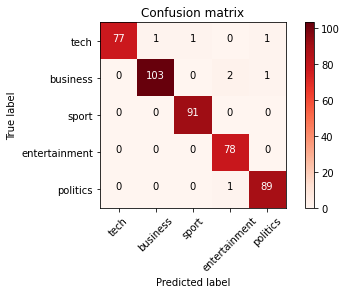

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels_val, predicted_labels)
cm_plot_labels = ['tech', 'business', 'sport', 'entertainment', 'politics']
plot_confusion_matrix(cm, cm_plot_labels)

## Free test here

In [ ]:
#Classifying random sentences
tests = getPrediction(['Mr.Modi is the Indian Prime Minister',
                       'Gaming machines are powered by efficient micro processores and GPUs',
                       'That HBO TV series is really good',
                       'A trillion dollar economy '
                       ])

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] mr . mod ##i is the indian prime minister [SEP]


INFO:tensorflow:tokens: [CLS] mr . mod ##i is the indian prime minister [SEP]


INFO:tensorflow:input_ids: 101 2720 1012 16913 2072 2003 1996 2796 3539 2704 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2720 1012 16913 2072 2003 1996 2796 3539 2704 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] gaming machines are powered by efficient micro processor ##es and gp ##us [SEP]


INFO:tensorflow:tokens: [CLS] gaming machines are powered by efficient micro processor ##es and gp ##us [SEP]


INFO:tensorflow:input_ids: 101 10355 6681 2024 6113 2011 8114 12702 13151 2229 1998 14246 2271 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 10355 6681 2024 6113 2011 8114 12702 13151 2229 1998 14246 2271 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] that hbo tv series is really good [SEP]


INFO:tensorflow:tokens: [CLS] that hbo tv series is really good [SEP]


INFO:tensorflow:input_ids: 101 2008 14633 2694 2186 2003 2428 2204 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2008 14633 2694 2186 2003 2428 2204 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] a trillion dollar economy [SEP]


INFO:tensorflow:tokens: [CLS] a trillion dollar economy [SEP]


INFO:tensorflow:input_ids: 101 1037 23458 7922 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1037 23458 7922 4610 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-166


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-166


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
tests

[('Mr.Modi is the Indian Prime Minister',
  array([-5.7944274 , -3.2766647 , -6.1044955 , -6.0811276 , -0.04637577],
        dtype=float32),
  4,
  'politics'),
 ('Gaming machines are powered by efficient micro processores and GPUs',
  array([-5.7623936e-03, -6.4207482e+00, -6.8260150e+00, -6.9579444e+00,
         -6.1743779e+00], dtype=float32),
  0,
  'tech'),
 ('That HBO TV series is really good',
  array([-5.6619344 , -6.28645   , -5.921807  , -0.01003294, -6.23216   ],
        dtype=float32),
  3,
  'entertainment'),
 ('A trillion dollar economy ',
  array([-6.1242361e+00, -6.6366023e-03, -6.6088715e+00, -6.9531231e+00,
         -6.1556211e+00], dtype=float32),
  1,
  'business')]

## Test by csv file

In [ ]:
test = pd.read_csv("test.csv")
pred_sentences = list(test['text'])

In [ ]:
predictions = getPrediction(pred_sentences)

In [ ]:
predictions[0]

In [ ]:
enc_labels = []
act_labels = []
for i in range(len(predictions)):
  enc_labels.append(predictions[i][2])
  act_labels.append(predictions[i][3])

In [ ]:
pd.DataFrame(act_labels, columns = ['category']).to_csv('submission_bert.csv', index = False)

Reference: https://analyticsindiamag.com/step-by-step-guide-to-implement-multi-class-classification-with-bert-tensorflow/